
# RAG Lab: PDF → Chunking → Embeddings → ChromaDB 
<img src="https://raw.githubusercontent.com/CNUClasses/CPSC471/master/content/lectures/week12/vector_upsert_pipeline.png" alt="standard" style="max-height:300px;  margin:10px 0; vertical-align:middle;">

**Build a small Retrieval-Augmented Generation (RAG) data pipeline:**
1. Load PDFs from a directory
2. Chunk the text using either **fixed-size** chunks with **overlap** or **LLM-assisted** segmentation
3. Embed the chunks with a compact Sentence-Transformers model
4. Store vectors and metadata in a local **ChromaDB** collection

**What you'll learn**
- Why chunking and overlap improve recall
- How to choose and use an embedding model consistently (same embedder for chunking and for retreival)
- How a local vector DB (ChromaDB) stores and retrieves embeddings

**Glossary**
- **Chunk**: A small slice of text extracted from documents.
- **Overlap**: Repeating some tokens between adjacent chunks to avoid cutting important context.
- **Embedding**: A fixed-length vector representation of text.
- **Vector DB**: A database that stores vectors and supports similarity search (e.g., top-k retrieval).
- **Top-k retrieval**: Return the k most similar chunks to a query (nearest neighbors).


In [1]:
# ✅ Install minimal dependencies. If these are already installed, this cell is a no-op.
# !pip install langchain langchain-community pypdf chromadb sentence-transformers transformers tqdm --quiet

In [2]:

# ---- Imports & configuration ----
import os, re, uuid, glob, math, json
from pathlib import Path
from typing import List, Dict, Any, Optional
from dataclasses import dataclass

import numpy as np
import pandas as pd
from tqdm import tqdm
import fitz  # PyMuPDF

# Embeddings
from sentence_transformers import SentenceTransformer

# --- Student-editable configuration ---
PDF_DIR = "./pdfs"                  # directory with source PDFs
PERSIST_DIR = "./rag_chroma"        # ChromaDB persistence path (folder will be created)
COLLECTION_NAME = "cnu_rag_lab"     # collection name
CHUNK_WORDS = 400                   # fixed-size chunk length (~words)
CHUNK_OVERLAP_WORDS = 40            # overlap between chunks (~words)
EMBED_MODEL_NAME = "sentence-transformers/msmarco-distilbert-cos-v5"
# USE_LLM_CHUNKING = False            # set True to try optional LLM-assisted chunking
MAX_PAGES_PER_PDF: Optional[int] = None  # set an int (e.g., 5) to limit pages for demos

# Sanity: ensure dirs exist
Path(PDF_DIR).mkdir(parents=True, exist_ok=True)
Path(PERSIST_DIR).mkdir(parents=True, exist_ok=True)


In [ ]:
# how many tokens can my model take (context window size)?
embedder = SentenceTransformer(EMBED_MODEL_NAME)
max_tokens_for_model=embedder.max_seq_length

# Estimate character count based on average token-to-character ratio (e.g., 4 characters per token)
# This is an approximation; precise tokenization depends on the model's tokenizer.
estimated_max_chars = max_tokens_for_model * 4  #use this to ensure chunks fit in model context window
# estimated_max_chars = 500

print(f"Embedding model: {EMBED_MODEL_NAME}, max context tokens={max_tokens_for_model}, estimated max characters={estimated_max_chars}")    

#get rid of model and reclaim memory
del embedder
embedder=None

# Run GC and release common GPU framework caches
import gc
gc.collect()

# PyTorch
import torch
try:
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
except Exception:
    pass


Embedding model: sentence-transformers/msmarco-distilbert-cos-v5, max context tokens=384, estimated max characters=1536



## 1) Load PDFs

We'll extract text with **PyPDFLoader** page-by-page. Empty or whitespace-only pages are dropped.  
**Why this matters:** We want a clean, normalized text corpus before chunking to ensure consistent chunk lengths and quality.


In [4]:
from langchain_community.document_loaders import PyPDFLoader
import glob

pages = []
pdf_files = glob.glob(os.path.join(PDF_DIR, "*.pdf"))
for pdf_path in pdf_files:
    loader = PyPDFLoader(pdf_path)
    pages.extend(loader.load())
print(f"Number pdf pages loaded={len(pages)}")
pages[0]

Number pdf pages loaded=330


Document(metadata={'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 20.4 (Windows)', 'creationdate': '2025-07-29T14:06:32-04:00', 'moddate': '2025-07-30T09:22:09-04:00', 'title': 'Christopher Newport University: Undergraduate Catalog 2019-20', 'trapped': '/False', 'source': './pdfs/2025-26-undergraduate_catalog.pdf', 'total_pages': 315, 'page': 0, 'page_label': '1'}, page_content='Undergraduate Catalog \nV olume 60, Number 1, July 2025 \nThe provisions of this catalog do not constitute a contract, expressed or implied, between any applicant or student and the \nRector and Board of Visitors of Christopher Newport University. The University reserves the right to change any of the provi-\nsions, schedules, programs, courses, rules, regulations, or fees whenever the University deems it expedient to do so. \nChristopher Newport University is committed to providing an environment that emphasizes the dignity and worth of every \nmember of its community and that is free from ha


## 2) Chunking (Fixed-Size with Overlap)

We'll implement a tokenizer-free word splitter and then slide a window with overlap.  
**Why overlap?** It preserves context that may straddle chunk boundaries, improving recall during retrieval.

BTW this is subtle and hardish to get right, maybe split just on paragraphs, that will get each class description as a single paragraph.


**Factors to Consider**

**Query Type:**

<u>Fact-based queries:</u>benefit from smaller chunks (e.g., 128-256 tokens) to pinpoint specific facts and improve retrieval accuracy. 


<u>Contextual or summarization queries:</u> require larger chunks (e.g., 256-512 tokens) to provide broader context and retain meaningful information. 

**Context width** You should also consider the embedding model's context window (e.g., if it supports 512 tokens, don't chunk larger) and experiment with overlapping chunks to preserve context.


In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=estimated_max_chars,  # Set chunk size in characters (~4 chars per token*tokens for model context window)
    chunk_overlap=200,  # Overlap between chunks (in characters)
    separators=["\n\n", "\n", "(?<=\. )"]  # Split on paragraphs, then lines, then sentences
)
# RecursiveCharacterTextSplitter attempts to split text at natural boundaries:
# 1. First tries double newlines (paragraph breaks)
# 2. Then single newlines (line breaks)  
# 3. Finally sentence endings (regex pattern for period followed by space)
# This preserves semantic coherence better than fixed-character splitting

In [6]:
#how many chunks
chunks=r_splitter.split_documents(pages)
print(f"Generated {len(chunks)} chunks")

Generated 1256 chunks


In [7]:
#strip out beginning and ending whitespace
for chunk in chunks:
    chunk.page_content = chunk.page_content.strip()

### Look what is inside each chunk, note the amount of information in the metadata field

In [18]:
# Display all attributes of a particular chunk
chunk_numb=5
print("Type:", type(chunks[chunk_numb]))
print("\nPage Content:")
print(chunks[chunk_numb].page_content)

print("\nMetadata:")
print(chunks[chunk_numb].metadata)
print("\nMetadata:Page")
print(chunks[chunk_numb].metadata['page'])

print("\nAll attributes of the chunk object:")
print(dir(chunks[chunk_numb]))

Type: <class 'langchain_core.documents.base.Document'>

Page Content:
tion. We rank as one of the safest campuses in Virginia and 
pride ourselves on investing in our infrastructure to provide 
opportunities for all. We have completed $1 billion in new 
capital construction, including: 
• A new Science and Engineering Research Center is 
under construction and will feature a two-story drone 
lab, maker space, and state-of-the-art demonstration 
classroom. 
• Stellar academic halls. McMurran Hall is home to 
our superb liberal arts programs. Forbes Hall, our 
integrated science center, provides a 21st-century 
hub for education and discovery. Luter Hall houses 
the Luter School of Business; Economics; Sociol -
ogy, Social Work and Anthropology; Leadership and 
American Studies; Mathematics; and the School of 
Engineering and Computing. 
• The Mary M. Torggler Fine Arts Center is a stun-
ning new addition to campus. Graced by an entry 
rotunda of cascading glass domes, the Torggler fea -

### What are the sizes of the chunks created?

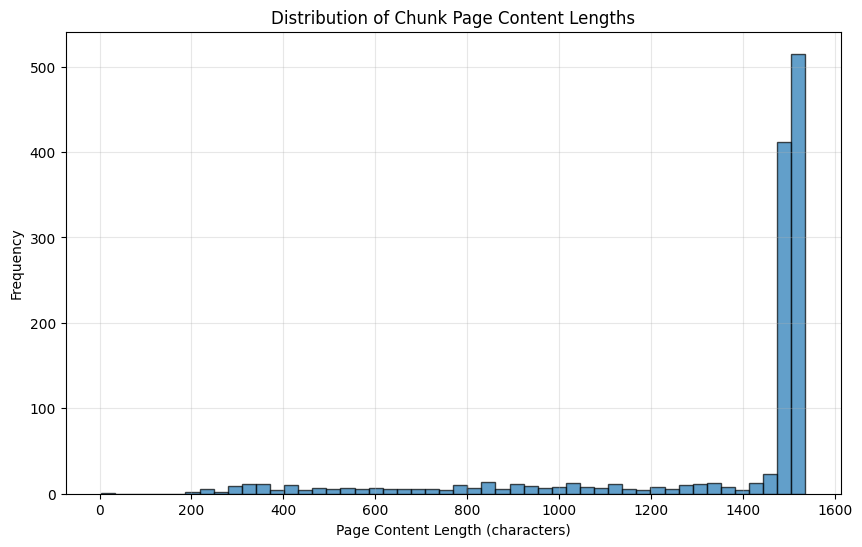

Total chunks: 1256
Min length: 3
Max length: 1535
Average length: 1348.86


In [9]:
import matplotlib.pyplot as plt

# Calculate the length of page_content for each chunk
chunk_lengths = [len(chunk.page_content) for chunk in chunks]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(chunk_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Page Content Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Chunk Page Content Lengths')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total chunks: {len(chunk_lengths)}")
print(f"Min length: {min(chunk_lengths)}")
print(f"Max length: {max(chunk_lengths)}")
print(f"Average length: {sum(chunk_lengths)/len(chunk_lengths):.2f}")


### <mark>IMPORTANT! Make sure your max page_content chunk size is <= your embedding models max token context window. (Approximated by 1 token ~ 4 chars here).  Anything longer is truncated.


## 3) Optional: LLM-Assisted Chunking (Semantic Segmentation)

**Idea:** Ask an LLM to segment a page into coherent sections (headings, paragraphs, lists). Then, for any very long segments, re-chunk using the fixed method above so that chunks stay small.

> This path is **optional** and requires an API key. If you set `USE_LLM_CHUNKING = True`, make sure `OPENAI_API_KEY` is in your environment. Keep your key private.


In [10]:

# def llm_segment_page(text: str, model: str = "gpt-4o-mini") -> List[str]:
#     '''
#     Use an LLM to segment the page text into coherent sections.
#     Returns a list of segments. On any error or short text, returns [text].
#     '''
#     text = text.strip()
#     if len(text.split()) < 80:
#         return [text]
#     try:
#         import os
#         api_key = os.getenv("OPENAI_API_KEY")
#         if not api_key:
#             # No key -> no network call; just fall back gracefully
#             return [text]

#         # Install only if needed
#         try:
#             from openai import OpenAI  # modern SDK
#         except Exception:
#             import sys
#             print("[INFO] Installing openai client...")
#             !{sys.executable} -m pip -q install --upgrade openai
#             from openai import OpenAI

#         client = OpenAI(api_key=api_key)

#         prompt = (
#             "You segment text into coherent sections such as headings and paragraphs. "
#             "Return a JSON list of strings where each string is a segment. "
#             "Keep segments between 150-400 words when possible.\n\n"
#             f"TEXT:\n{text[:8000]}"
#         )
#         resp = client.responses.create(
#             model=model,
#             input=[{"role":"user","content":prompt}],
#             response_format={"type":"json_object"}
#         )
#         # Extract JSON safely
#         content = resp.output[0].content[0].text  # SDK shapes can vary; adjust if needed
#         import json as _json
#         parsed = _json.loads(content)
#         segments = parsed.get("segments") or parsed.get("data") or parsed.get("list")
#         if isinstance(segments, list) and all(isinstance(s, str) for s in segments):
#             # light cleanup
#             segments = [s.strip() for s in segments if s.strip()]
#             return segments or [text]
#         return [text]
#     except Exception as e:
#         # Silent, robust fallback
#         return [text]

# def rechunk_if_long(segments: List[str], max_words: int = 600) -> List[str]:
#     '''If a segment is too long, re-chunk with the fixed method to keep sizes bounded.'''
#     out = []
#     for s in segments:
#         if len(words(s)) > max_words:
#             out.extend(chunk_fixed(s, CHUNK_WORDS, CHUNK_OVERLAP_WORDS))
#         else:
#             out.append(s)
#     return out

# def chunk_pages_llm(page_records: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
#     '''
#     Segment each page via LLM, then bound segment length. Tag method='llm'.
#     Requires OPENAI_API_KEY for actual LLM calls; otherwise falls back implicitly.
#     '''
#     out = []
#     for rec in tqdm(page_records, desc="LLM segmenting pages"):
#         segs = llm_segment_page(rec["text"])
#         segs = rechunk_if_long(segs, max_words=600)
#         for s in segs:
#             out.append({
#                 "chunk_id": str(uuid.uuid4()),
#                 "doc_id": rec["doc_id"],
#                 "source": rec["source"],
#                 "page": rec["page"],
#                 "method": "llm",
#                 "text": s
#             })
#     return out

# chunk_records_llm = chunk_pages_llm(pages) if (pages and USE_LLM_CHUNKING) else []
# print(f"LLM-assisted path produced {len(chunk_records_llm)} chunks (0 if not enabled).")


## 4) Gather the data that goes into a VectorDB

These lists are built to conform to ChromaDB upsert API

In [ ]:
sources=[chunk.metadata['source'] for chunk in chunks]      #the doc the chunk came from
pages=[chunk.metadata['page'] for chunk in chunks]          #the page in the doc where the chunk came from
metadatas=[{"source": sources[i],
            "page": pages[i]} for i in range(len(chunks))]  #can put whatever you want in metadatas

ids=[str(i) for i in range(len(chunks))]                    #just a way to have unique IDs
documents=[chunk.page_content for chunk in chunks]          #the raw text chunks

# print(len(documents))
# print(documents[0] )
# print(metadatas[:10])

## 5) Embedd documents for Semantic Search

Semantic search seeks to improve search accuracy by understanding the semantic meaning of the search query and the corpus to search over. Semantic search can also perform well given synonyms, abbreviations, and misspellings, unlike keyword search engines that can only find documents based on lexical matches.

**Background**

The idea behind semantic search is to embed all entries in your corpus, whether they be sentences, paragraphs, or documents, into a vector space. At search time, the query is embedded into the same vector space and the closest embeddings from your corpus are found. These entries should have a high semantic similarity with the query.

![SemanticSearch](https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/docs/img/SemanticSearch.png)

**Symmetric vs. Asymmetric Semantic Search**

A **critical distinction** for your setup is *symmetric* vs. *asymmetric semantic search*:

- For **symmetric semantic search** your query and the entries in your corpus are of about the same length and have the same amount of content. An example would be searching for similar questions: Your query could for example be *"How to learn Python online?"* and you want to find an entry like *"How to learn Python on the web?"*. For symmetric tasks, you could potentially flip the query and the entries in your corpus.
  - Related training example: [Quora Duplicate Questions](../../training/quora_duplicate_questions/README.md).
  - Suitable models: [Pre-Trained Sentence Embedding Models](../../../../docs/sentence_transformer/pretrained_models.md)
- For **asymmetric semantic search**, you usually have a **short query** (like a question or some keywords) and you want to find a longer paragraph answering the query. An example would be a query like *"What is Python"* and you want to find the paragraph *"Python is an interpreted, high-level and general-purpose programming language. Python's design philosophy ..."*. For asymmetric tasks, flipping the query and the entries in your corpus usually does not make sense.
  - Related training example: [MS MARCO](../../training/ms_marco/README.md)
  - Suitable models: [Pre-Trained MS MARCO Models](../../../../docs/pretrained-models/msmarco-v5.md)

It is critical **that you choose the right model** for your type of task.

```{eval-rst}
.. tip::

    For asymmetric semantic search, you are recommended to use :meth:`SentenceTransformer.encode_query <sentence_transformers.SentenceTransformer.encode_query>` to encode your queries and :meth:`SentenceTransformer.encode_document <sentence_transformers.SentenceTransformer.encode_document>` to encode your corpus. 
    
    
```

In [ ]:
# Load the embedder
embedder = SentenceTransformer(EMBED_MODEL_NAME)
print("Embedding model loaded:", EMBED_MODEL_NAME)

#encode in batches
batch_size = 64
embeddings = []
for i in tqdm(range(0, len(chunks), batch_size), desc="Embedding chunks"):
    # batch_texts = df['text'].iloc[i:i+batch_size].tolist()
    batch_texts=documents[i:i+batch_size]
    
    #if using sentence transformer use encode_document to embed your corpus
    batch_vecs = embedder.encode_document(batch_texts, batch_size=min(32, len(batch_texts)), show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=True)
    embeddings.append(batch_vecs)

# print("Embeddings shape:", len(embeddings[0]))
embeddings = np.vstack(embeddings).astype("float32")
print("Embeddings shape:", embeddings.shape)

Embedding model loaded: sentence-transformers/msmarco-distilbert-cos-v5


Embedding chunks: 100%|██████████| 20/20 [00:03<00:00,  6.19it/s]

Embeddings shape: 64
Embeddings shape: (1256, 768)


In [22]:
#what is the max token length for this embedder
print(f'Embedding model {EMBED_MODEL_NAME} max token sequence length: {embedder.max_seq_length} which is ~{embedder.max_seq_length*4} characters')


Embedding model sentence-transformers/msmarco-distilbert-cos-v5 max token sequence length: 384 which is ~1536 characters



## 6) ChromaDB: Create / Persist Collection

We'll use a **PersistentClient** so your vectors survive across sessions in `PERSIST_DIR`.  
**Why this matters:** Persistence lets you build once and query many times (like in the next Lab).


In [14]:
import chromadb

# Persistent client that will store the data
client = chromadb.PersistentClient(path=PERSIST_DIR)

try:
    # Delete the collection if it exists
    client.delete_collection(name=COLLECTION_NAME)
    print(f"Collection '{COLLECTION_NAME}' deleted successfully.")
except Exception as e:
    print(f"Error deleting collection '{COLLECTION_NAME}': {e}")

collection = client.create_collection(
    name=COLLECTION_NAME,
    metadata={"hnsw:space": "cosine"},
    embedding_function=None)


Collection 'cnu_rag_lab' deleted successfully.


**Push all content to the vector DB**

Note the expected inputs of collection.upsert

In [15]:
collection.upsert??

Signature:
collection.upsert(
    ids: Union[str, List[str]],
    embeddings: Union[numpy.ndarray[tuple[Any, ...], numpy.dtype[Union[numpy.int32, numpy.float32]]], List[numpy.ndarray[tuple[Any, ...], numpy.dtype[Union[numpy.int32, numpy.float32]]]], Sequence[float], Sequence[int], List[Union[Sequence[float], Sequence[int]]], NoneType] = None,
    metadatas: Union[Mapping[str, Union[str, int, float, bool, chromadb.base_types.SparseVector, NoneType]], List[Mapping[str, Union[str, int, float, bool, chromadb.base_types.SparseVector, NoneType]]], NoneType] = None,
    documents: Union[str, List[str], NoneType] = None,
    images: Union[numpy.ndarray[tuple[Any, ...], numpy.dtype[Union[numpy.uint64, numpy.int64, numpy.float64]]], List[numpy.ndarray[tuple[Any, ...], numpy.dtype[Union[numpy.uint64, numpy.int64, numpy.float64]]]], NoneType] = None,
    uris: Union[str, List[str], NoneType] = None,
) -> None
Source:   
    def upsert(
        self,
        ids: OneOrMany[ID],
        embeddings: 

In [ ]:

collection.upsert(
    ids=ids,   
    embeddings=embeddings,
    metadatas=metadatas,
    documents=documents
)
print(f"Collection '{COLLECTION_NAME}' now has {collection.count()} vectors. Persisted at: {PERSIST_DIR}")

# Access the configuration to find the distance metric (space)
print(f"The distance metric is: {collection.metadata.get('hnsw:space') }")

Collection 'cnu_rag_lab' now has 1256 vectors. Persisted at: ./rag_chroma
The distance metric is: cosine


## 7) Reduce dimensionaily of embeddings and plot 

Losing a lot of info here (going from 384 to 2) so plot may not be accurate<br><br>
PCA is fast but linear, it **cannot** capture non linear relationships<br>
UMAP is slow and non linear, it **can** capture non linear relationships

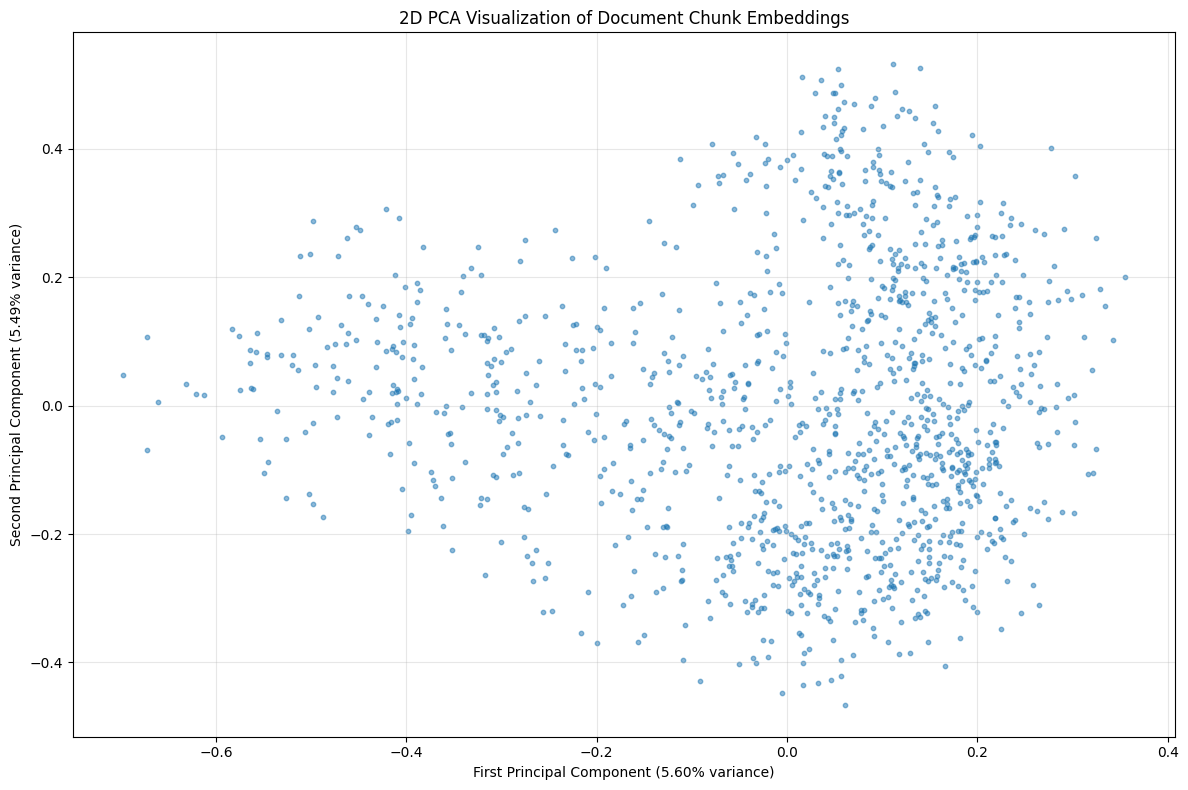

Total variance explained by 2 components: 11.09%


In [ ]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Reduce embeddings to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5, s=10)
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('2D PCA Visualization of Document Chunk Embeddings')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#the following is a proxy for how much of the original information PCA captures (looks like its not much here)
print(f"Total variance explained by 2 components: {pca.explained_variance_ratio_.sum():.2%}")

/home/kperkins411/anaconda3/envs/ultralytics/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


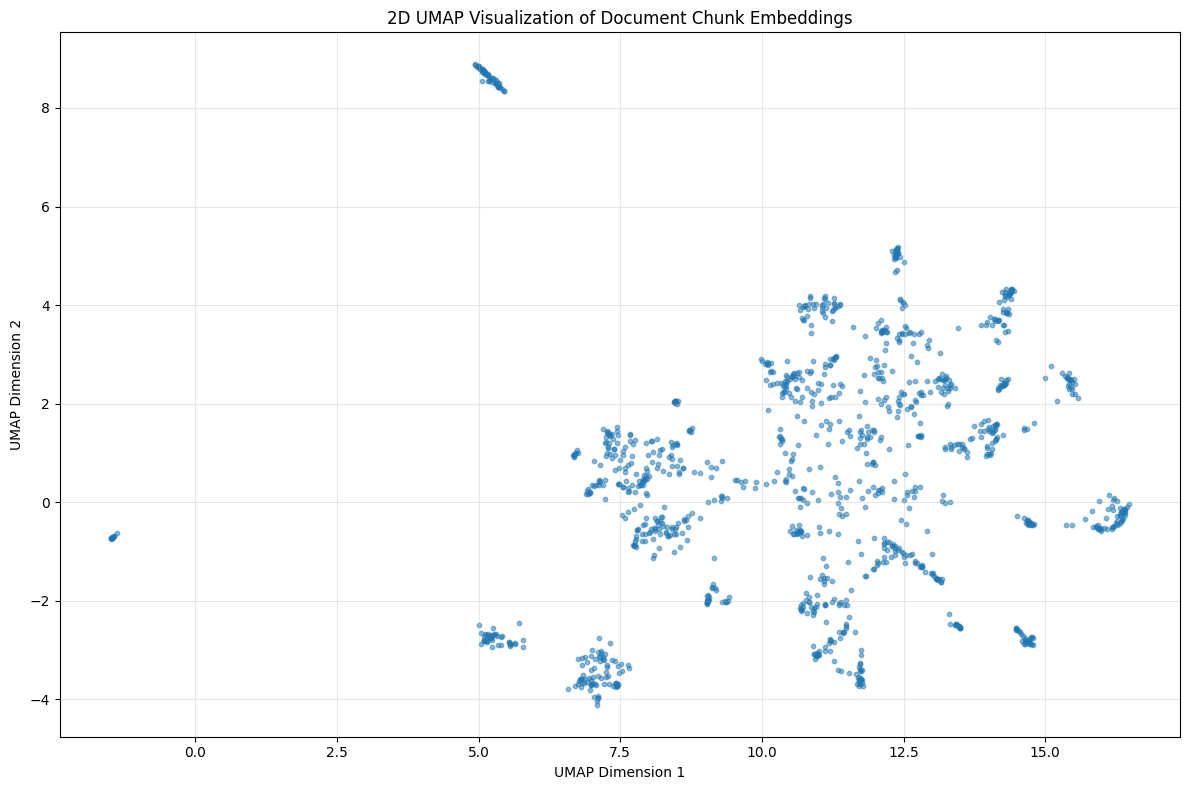

Total chunks visualized: 1256


In [24]:
from umap import UMAP

import matplotlib.pyplot as plt

# Reduce embeddings to 2D using UMAP
reducer = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embeddings_2d_umap = reducer.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d_umap[:, 0], embeddings_2d_umap[:, 1], alpha=0.5, s=10)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('2D UMAP Visualization of Document Chunk Embeddings')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total chunks visualized: {len(embeddings_2d_umap)}")


## 8) Wrap‑Up & Next Steps

**Key takeaways**
- Fixed-size chunks with overlap are simple and reliable; LLM-assisted segmentation can yield cleaner semantic boundaries but requires an API key and careful prompting.
- Use the **same** embedding model for both documents and queries.
- Persisting to ChromaDB allows fast iteration without re-embedding every run.

**Try next**

- <mark>For step 7 above, note the UMAP projection makes the chunks look like they belong to clusters.  It would be interesting to cluster the chunks and then ask an LLM to determine each clusters 'theme' or main idea is.</mark>
- Tune `CHUNK_WORDS`/`CHUNK_OVERLAP_WORDS`.
- Swap the embedder: e.g., `"BAAI/bge-small-en-v1.5"` (remember to re-embed queries too).


Happy building! 🎓


## Test Code

In [17]:
q1="I like yummy beans"
q2="I enjoy tasty legumes"
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
q1_emb=embedder.encode([q1], convert_to_numpy=True, normalize_embeddings=True)
q2_emb=embedder.encode([q2], convert_to_numpy=True, normalize_embeddings=True)

print("chromaDB uses cosine distance which ranges from 0 to 2, cosine similarity ranges from -1 to 1")
print("cosine similarity + cosine distances =1")
print(f'cosine_similarity(q1_emb, q2_emb): {cosine_similarity(q1_emb, q2_emb)}')
print(f'cosine_distances(q1_emb, q2_emb): {cosine_distances(q1_emb, q2_emb)}')

chromaDB uses cosine distance which ranges from 0 to 2, cosine similarity ranges from -1 to 1
cosine similarity + cosine distances =1
cosine_similarity(q1_emb, q2_emb): [[0.50056314]]
cosine_distances(q1_emb, q2_emb): [[0.49943686]]
